In [420]:
import filenistview 
import random
import pickle
import numpy as np
import sys
import torch
import math
import scipy.fft 

import matplotlib.pyplot as plt

In [2]:
# accessing datasets

# original dataset 
#nvldata = filenistview.FileHandlerNVL.load("BSCOData/OPT35K/70824A05 NVL cropped.nvl")

# dataset 2
#nvldata = filenistview.FileHandlerNVL.load("BSCOdata/UD25K/drift-corrected 0705C022 dIdV, Qx=(51,46).nvl")

# dataset 3
#nvldata = filenistview.FileHandlerNVL.load("BSCOdata/UD32K/1016B012 dIdV, cropcorner=(112,7), linesubtract, filtered N=5.nvl")

# dataset 4
#nvldata = filenistview.FileHandlerNVL.load("BSCOdata/OD15K/drift-corrected 70213M00_5K dIdV, Qx=(48,-3).nvl")

# dataset 5
#nvldata = filenistview.FileHandlerNVL.load("BSCOData/OPT35K/drift-corrected 0822F008 dIdV, Qx=(136,132), shift=(-1,1).nvl")

In [2]:
def extract_w(model_name):
    model = pickle.load(open(model_name, "rb"))
    for param in model.parameters():
        weights = param.data
        break
            
    return weights.cpu().numpy()

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y

def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / math.sqrt((a*a).sum() * (b*b).sum());
    return r

# Create correlation arrays

In [3]:
def create_corr(methodnum, material):
    corr_array = np.zeros((41, 41))
    
    # file names for material 1 don't have a "1" at the end
    if material == 1: material = "" 
    
    # methods 1 and 1.5 compare to one fixed matrix
    if methodnum < 2:
        if methodnum == 1: 
            w1 = extract_w("Models/NewModels/OneLayer1right0down" + str(material) + ".pickle")
        if methodnum == 1.5: 
            w1 = extract_w("Models/NewModels/OneLayer20right20down" + str(material) + ".pickle")
        
        for delta_x in range(41):
            for delta_y in range(41):
                if delta_x == 0 and delta_y == 0: continue

                model2 = "Models/NewModels/" + "OneLayer" + str(delta_x) + "right" + \
                    str(delta_y) + "down" + str(material) + ".pickle"
                corr = corr2(w1, extract_w(model2))

                corr_array[delta_y, delta_x] = corr
        
    # method 2 compares a model to the 0right model in its row
    elif methodnum == 2:    
        for delta_y in range(41):
            if delta_y == 0: continue
                
            w1 = extract_w("Models/NewModels/OneLayer0right" + str(delta_y) + \
                "down" + str(material) + ".pickle")

            for delta_x in range(41):
                model2 = "Models/NewModels/" + "OneLayer" + str(delta_x) + "right" + \
                    str(delta_y) + "down" + str(material) + ".pickle"
                corr = corr2(w1, extract_w(model2))
                
                corr_array[delta_y, delta_x] = corr
                
    ## approach 3: compare every model to the 0down model in its column
    elif methodnum == 3:
        for delta_x in range(41):
            if delta_x == 0: continue
                
            w1 = extract_w("Models/NewModels/OneLayer" + str(delta_x) + "right0down" + \
                str(material) + ".pickle")

            for delta_y in range(41):
                model2 = "Models/NewModels/" + "OneLayer" + str(delta_x) + "right" + \
                    str(delta_y) + "down" + str(material) + ".pickle"
                corr = corr2(w1, extract_w(model2))
                
                corr_array[delta_y, delta_x] = corr
    
    return corr_array

In [4]:
def plotcorr(corr):
    max_value = -10
    min_value = 10
    for i in range(41):
        for j in range(41):
            value = corr[i][j]
            if value > max_value:
                max_value = value
            if value < min_value:
                min_value = value

    print(max_value)
    print(min_value)

    plt.figure(figsize=(5.2, 5.2))
    x_ticks = np.arange(0,41,2)
    plt.xticks(x_ticks)
    y_ticks = np.arange(0,41,2)
    plt.yticks(y_ticks)
    plt.xlabel("Number of pixels to the right")
    plt.ylabel("Number of pixels down")
    plt.imshow(corr, cmap='bwr', vmin = -1.0, vmax = 1.0)
    plt.show()

1.0000000086950183
-0.21082945974357573


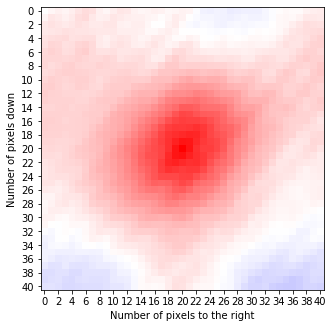

In [421]:
# plotcorr(corr_array1)
plotcorr(create_corr(1.5, 6))
# plotcorr(corr_array2)
# plotcorr(corr_array3)

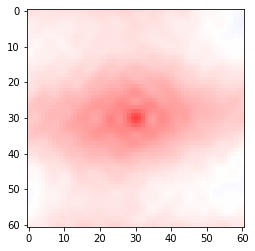

In [546]:
#plt.imshow(np.log10(corr_array1_5 + 1.0), cmap='bwr', vmin = -0.3, vmax = 0.3)
#plotcorr(np.log10(corr_array1_5 + 1.0))
plt.imshow(ffourier(create_corr(1.5, 7))[30:91, 30:91], cmap = 'bwr', vmin = -1.5e-1, vmax = 1.5e-1)
plt.show()
#plt.imshow(np.log10(ffourier(create_corr(1.5, 6)) + 1.0), cmap = 'bwr', vmin = -1e-1, vmax = 1e-1)

# FFT

In [5]:
def ffourier(orig):
    rows = orig.shape[0]
    corr_array1_zeros = np.zeros((rows*3, rows*3), dtype=complex)

    k = scipy.fft.fft2(orig.astype(np.float))
    k = scipy.fft.fftshift(k)
    corr_array1_zeros[rows:(rows*2), rows:(rows*2)] = k
    k = corr_array1_zeros
    k = scipy.fft.ifftshift(k)
    k = scipy.fft.ifft2(k)
    
    return np.real(k)

In [208]:
x = 0.05
y = .1
# plt.imshow(ffourier(np.log(corr_array1 + 1.0)), cmap='bwr', vmin = -x, vmax = x)
# plt.show()
# plt.imshow(ffourier(np.log(corr_array1_5 + 1.0)), cmap='bwr', vmin = -y, vmax = y)
# plt.show()

In [270]:
#plt.imshow(np.abs(x**2))

In [209]:
#plt.imshow(corr_array1)

In [586]:
#x = np.zeros((41, 41))
#corr_array1_zeros = np.zeros((123, 123), dtype=complex)

#x = scipy.fft.fftn(corr_array1_zeros)
k = scipy.fft.fft2(create_corr(1.5, 6))
#print(x.shape)
k = scipy.fft.fftshift(k)

# corr_array1_zeros[41:82, 41:82] = k
# k = corr_array1_zeros
# k = scipy.fft.ifftshift(k)
# k = scipy.fft.ifft2(k)

# plt.imshow(corr_array1, cmap='bwr', vmin = -1, vmax = 1)
# plt.show()
fft_lattice = k
k_mags = np.abs(k)

# k = scipy.fft.fft2(corr_array1_5)
# k = scipy.fft.fftshift(k)
# plt.imshow(np.real(k), cmap='bwr', vmin = -x, vmax = x)
# plt.show()

#x2 = np.zeros((123, 123))
#x2 = scipy.fft.ifftn(corr_array1_zeros)
#x2 = scipy.fft.ifftn(x)
#x2 = np.abs(x2**2)

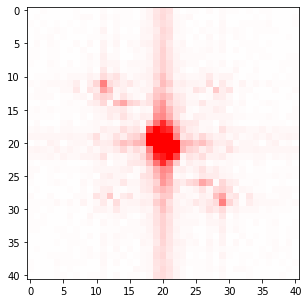

In [590]:
plt.figure(figsize=(5,5))
x = 15.0
plt.imshow(k_mags, cmap='bwr', vmin = -x, vmax = x)

# ax = plt.gca()
# ax.set_xticks(np.arange(0, 40, 1))
# ax.set_yticks(np.arange(0, 40, 1))
# ax.grid()

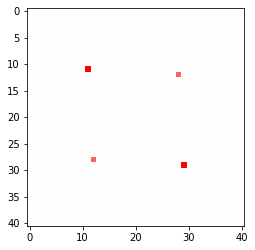

In [602]:
r = 6 # "radius" of the square that's cut out of the center

fft_filtered = np.zeros((41, 41), dtype=complex)
for i in range(41):
    for j in range(41):
        if (i > 20 - r and i < 20 + r) and (j > 20-r and j < 20+r): continue
        
        # for material 6
        if j > 16 and j < 24: continue
        if i == 5 or i == 35: continue
        
        if k_mags[i,j] > 6: fft_filtered[i,j] = k[i,j]

# for material 6
fft_filtered[12,28] = k[12,28]
fft_filtered[28,12] = k[28,12]

plt.imshow(np.abs(fft_filtered), cmap='bwr', vmin = -5, vmax = 5)

# Extract a lattice from an FFT

In [258]:
#plt.imshow(fft,cmap='bwr', vmin=-.1, vmax=.1)

In [603]:
ifft_filtered = scipy.fft.ifftshift(fft_filtered)
fft = np.real(scipy.fft.ifftn(ifft_filtered))

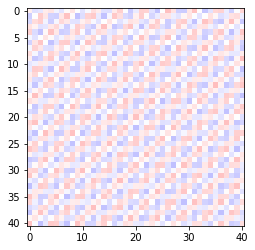

In [604]:
x = 5e-2
plt.imshow(fft, cmap='bwr', vmin = -x, vmax = x)

711.0
969.0


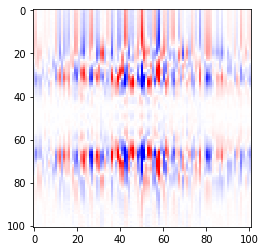

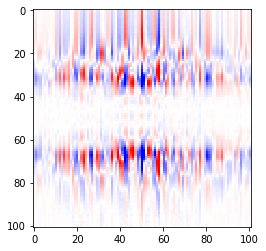

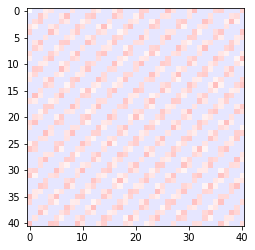

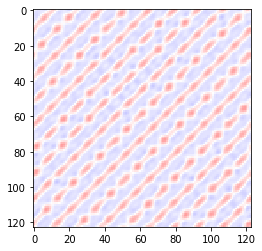

In [605]:
lattice = np.zeros((41, 41))
w_dim = 101
avg_w_red = np.zeros((w_dim, w_dim)) # average weights matrix
avg_w_blue = np.zeros((w_dim, w_dim))
count_red = 0.0
count_blue = 0.0

for i in range(41):
    for j in range(41):
        if (i == 0 and j == 0): continue
#         if (checkerboard[i][j] == 0.5): 
#             lattice[i, j] = checkerboard[i, j]
        if (fft[i][j] > 0.002): 
            lattice[i, j] = fft[i, j]
            #lattice[i, j] = 0.05
            count_red += 1.0
            
            name = "Models/NewModels/OneLayer" + str(j) + "right" + str(i) + "down6.pickle"
            avg_w_red = np.add(avg_w_red, extract_w(name))
        else:
            count_blue += 1.0
            lattice[i, j] = -0.005
            
            name = "Models/NewModels/OneLayer" + str(j) + "right" + str(i) + "down6.pickle"
            avg_w_blue = np.add(avg_w_blue, extract_w(name))

x= 0.2
y = 0.05
z = 0.005
avg_w_red /= count_red
avg_w_blue /= count_blue
pickle.dump(avg_w_red, open("RedWeights6.pickle", "wb"))
pickle.dump(avg_w_blue, open("BlueWeights6.pickle", "wb"))

print(count_red)
print(count_blue)

plt.imshow(avg_w_red, cmap='bwr', vmin = -x, vmax = x)
plt.show()
plt.imshow(avg_w_blue, cmap='bwr', vmin = -x, vmax = x)
plt.show()
plt.imshow(lattice, cmap='bwr', vmin=-y, vmax=y)
plt.show()
plt.imshow(ffourier(lattice), cmap='bwr', vmin=-z, vmax=z)
plt.show()
#print(count)

In [367]:
print(fft[0][1])

-0.019587539232537386


 # Checkerboard pattern creation
 

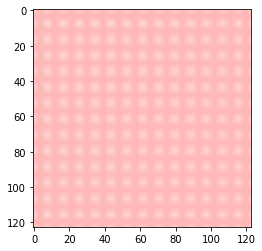

In [406]:
# create a checkerboard where values are 0 or 1, where 1 is group A
checkerboard = np.zeros((41, 41))
for i in range(41):
    for j in range(41):
        if (i % 3 == 1) or (j % 3 == 1): 
            checkerboard[i][j] = 0.5
        else:  
            checkerboard[i][j] = 0.4

plt.imshow(ffourier(checkerboard), cmap='bwr', vmin = -.2, vmax = .2)

# Outdated below

In [23]:
# plt.imshow(corr_array1)
# plt.show()
# plt.imshow(np.real(x))
# plt.show()
# plt.imshow(np.real(corr_array1_zeros))
# plt.show()
# plt.imshow(np.imag(x2))
# #plt.imshow(x2)
# plt.show()

In [211]:
x = scipy.fft.fft2(corr_array1)
x2 = np.log(np.abs(x**2))
#plt.imshow(x2)

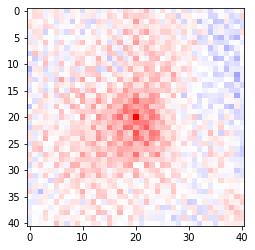

In [164]:
plt.imshow(corr_array1_5, cmap='bwr', vmin=-1, vmax=1)

In [210]:
corr_array = create_corr(1.5, 3)

In [211]:
lattice = np.zeros((41,41))
# sum1 = 0.0
# sum2 = 0.0
avg_w_red = np.zeros((41, 41)) # average weights matrix
avg_w_blue = np.zeros((41, 41))
count_red = 0.0
count_blue = 0.0

for i in range(41):
    for j in range(41):
        corr = corr_array[i][j] 
        if (i + j) % 4 == 0: 
            #lattice[i][j] = 0.3
            if corr > 0.05 and corr < 0.4: 
                lattice[i][j] = .2
                count_red += 1.0

                name = "Models/NewModels/OneLayer" + str(j) + "right" + str(i) + "down3.pickle"
                avg_w_red = np.add(avg_w_red, extract_w(name))
                #sum1 += corr
        
        elif (i + j) % 4 == 1: 
            #lattice[i][j] = -0.1
            if corr > -0.3 and corr < 0.1: 
                lattice[i][j] = -.2
                count_blue += 1.0
                name = "Models/NewModels/OneLayer" + str(j) + "right" + str(i) + "down3.pickle"
                avg_w_blue = np.add(avg_w_blue, extract_w(name))
                #sum2 += corr

avg_w_red /= count_red
avg_w_blue /= count_blue

print(count_red)
print(count_blue)

x = .1
# plt.imshow(avg_w_red, cmap='bwr', vmin = -x, vmax = x)
# plt.show()
# plt.imshow(avg_w_blue, cmap='bwr', vmin = -x, vmax = x)
# plt.show()

# # print(sum1 / 841)
# # print(sum2 / 840)

# plt.imshow(lattice, cmap='bwr', vmin = -.7, vmax = .7)

208.0
256.0


# Making lattices with separate regions

In [60]:
corr_array = create_corr(1.5, 3)
#plt.imshow(corr_array, cmap='bwr', vmin=-1, vmax=1)

In [56]:
# create a diamond: in a 41x41 boolean array, corners are True, and diamond is False
diamond = (np.zeros((41, 41)) != 0.0)
for i in range(41):
    for j in range(41):
        # top left corner 
        if i < 21 and j < 21 and (i + j) < 21: diamond[i][j] = True
        # bottom left corner
        if i > 20 and j < 21 and ((40 - i) + j) < 21: diamond[i][j] = True
        # top right corner 
        if i < 21 and j > 20 and (i + (40 - j)) < 21: diamond[i][j] = True
        # bottom right corner
        if i > 20 and j > 20 and ((40 - i) + (40 - j)) < 21: diamond[i][j] = True

In [61]:
# test that diamond works
# temp = np.zeros((41, 41))
# for i in range(41):
#     for j in range(41):
#         if diamond[i][j]: temp[i][j] = corr_array[i][j]

# plt.imshow(temp, cmap='bwr', vmin=-1, vmax=1)

375.0
444.0


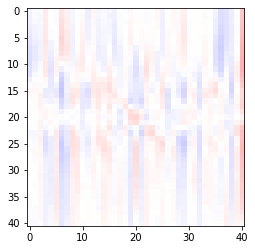

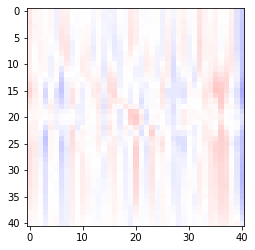

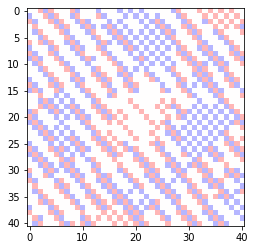

In [62]:
lattice = np.zeros((41,41))
# sum1 = 0.0
# sum2 = 0.0
avg_w_red = np.zeros((41, 41)) # average weights matrix
avg_w_blue = np.zeros((41, 41))
count_red = 0.0
count_blue = 0.0

for i in range(41):
    for j in range(41):
        corr = corr_array[i][j] 
        if (i + j) % 2 == 0: 
            #lattice[i][j] = 0.3
            if ((not diamond[i][j]) and corr > 0.15 and corr < 0.4) or \
                (diamond[i][j] and corr > 0.0 and corr < 0.4): # if diamond or corner, resp.
                
                lattice[i][j] = .2
                count_red += 1.0

                name = "Models/NewModels/OneLayer" + str(j) + "right" + str(i) + "down3.pickle"
                avg_w_red = np.add(avg_w_red, extract_w(name))
                #sum1 += corr
        
        elif (i + j) % 2 == 1: 
            #lattice[i][j] = -0.1
            if ((not diamond[i][j]) and corr > -0.3 and corr < 0.15) or \
                (diamond[i][j] and corr > -0.3 and corr < 0.0): # if diamond or corner, resp.
                
                lattice[i][j] = -.2
                count_blue += 1.0
                name = "Models/NewModels/OneLayer" + str(j) + "right" + str(i) + "down3.pickle"
                avg_w_blue = np.add(avg_w_blue, extract_w(name))
                #sum2 += corr

avg_w_red /= count_red
avg_w_blue /= count_blue

print(count_red)
print(count_blue)

x = .1
plt.imshow(avg_w_red, cmap='bwr', vmin = -x, vmax = x)
plt.show()
plt.imshow(avg_w_blue, cmap='bwr', vmin = -x, vmax = x)
plt.show()

# print(sum1 / 841)
# print(sum2 / 840)

plt.imshow(lattice, cmap='bwr', vmin = -.7, vmax = .7)

# "Average" weights matrices (older)

235.0
188.0


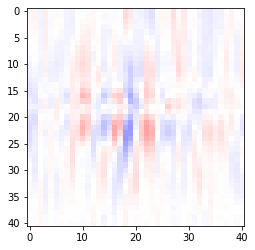

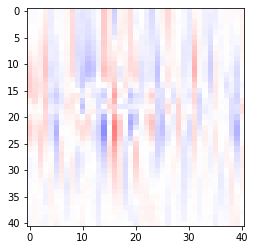

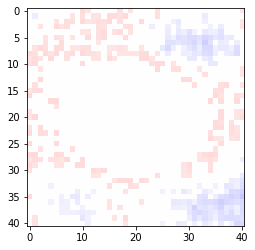

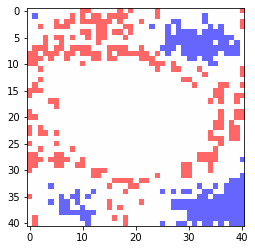

In [118]:
def avg_array(corr): # corr is the 41 x 41 correlation array
    avg_w_red = np.zeros((41, 41)) # average weights matrix for (x)right
    avg_w_blue = np.zeros((41, 41))
    pix_locations = np.zeros((41, 41)) # don't change
    check_locations = np.zeros((41, 41))
    count_red = 0.0
    count_blue = 0.0

    for r in range(41):
        for c in range(41):
            if corr[r][c] < 0.1 or corr[r][c] > 0.15: continue
            pix_locations[r][c] = corr[r][c]
            check_locations[r][c] = 0.6
            count_red += 1.0

            name = "Models/NewModels/OneLayer" + str(c) + "right" + str(r) + "down4.pickle"
            avg_w_red = np.add(avg_w_red, extract_w(name))

        for c in range(41):
            if corr[r][c] > -0.05: continue
            count_blue += 1.0
            pix_locations[r][c] = corr[r][c]
            check_locations[r][c] = -0.6
            
            name = "Models/NewModels/OneLayer" + str(c) + "right" + str(r) + "down4.pickle"
            avg_w_blue = np.add(avg_w_blue, extract_w(name))


    avg_w_red /= count_red
    avg_w_blue /= count_blue

    print(count_red)
    print(count_blue)

    x = .3
    y = 1.0
    plt.imshow(avg_w_red, cmap='bwr', vmin = -x, vmax = x)
    plt.show()
    plt.imshow(avg_w_blue, cmap='bwr', vmin = -x, vmax = x)
    plt.show()
    plt.imshow(pix_locations, cmap='bwr', vmin = -y, vmax = y)
    plt.show()
    plt.imshow(check_locations, cmap='bwr', vmin = -1.0, vmax = 1.0)
    plt.show()
    
avg_array(corr_array1_5)
#avg_array(corr_array2)
#avg_array(corr_array3)

0.9999999877816861
-0.11057676149115636


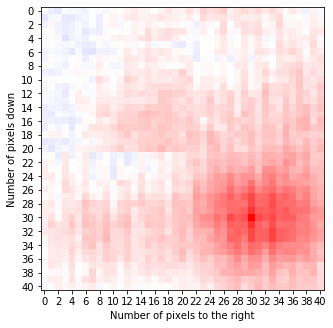

In [123]:
plotcorr(corr_array1_5)

In [53]:
corr_list = []
for i in range(2, 11):
    w2 = extract_w("Models/OneLayer" + str(i) + "left.pickle")
    corr = corr2(w1,w2)
    print(str(i) + ": " + str(corr))
    corr_list.append(corr)

2: 0.659423059642
3: 0.300620613068
4: 0.579130568223
5: 0.603467595225
6: 0.324430756264
7: -0.0437733768142
8: 0.48778616471
9: 0.338713221819
10: -0.172260286937


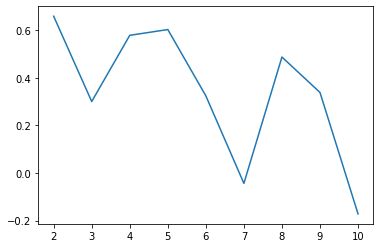

In [54]:
x_axis = list(range(2, 11))
plt.plot(x_axis, corr_list)

In [81]:
def extract_w(model_name):
    model = pickle.load(open(model_name, "rb"))
    for param in model.parameters():
        weights = param.data
        break
            
    return weights

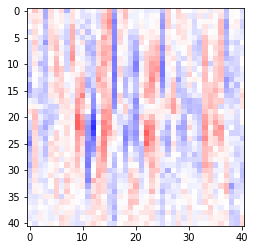

In [101]:
weights = extract_w("Models/NewModels/OneLayer5right18down4.pickle").cpu()
plt.imshow(weights, cmap='bwr', vmin = -.3, vmax = .3)
plt.show()

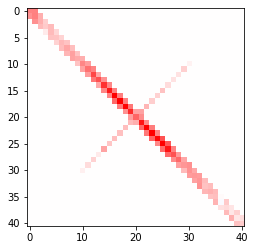

In [12]:
weights = extract_w("Models/OneLayer1spot3.pickle").cpu()
weights_new = np.zeros((41,41))
weights_new[0][:2] = weights[0][:2]
for i in range(1,40):
    weights_new[i][(i-1):(i+2)] = weights[i][(i-1):(i+2)]

weights_new[40][39:] = weights[40][39:]

for i in range(10,31):
    weights_new[i][40-i] = weights[i][40-i]
    
plt.imshow(weights_new, cmap='bwr', vmin = -.3, vmax = .3)
plt.show()